# P1. CIFAR10 CNN: training using minibatch gradient descent algorithms

Evaluate and plot the average training loss per epoch versus the number of epoches for the training dataset, for the following optimization algorithms: 

Mini-batch gradient descent 

Mini-batch AdaGrad 

Mini-batch RMSProp 

Mini-batch gradient descent with Nesterov’s momentum 

Mini-batch Adam

Also compare without dropout and adding dropout.

In [144]:
# importing necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.utils import shuffle

# deep learning framework
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2

# ML modules
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Flatten, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# data preprocessing
from tensorflow.keras.utils import to_categorical

In [64]:
from keras.datasets import cifar10 # a 10-class dataset used for figure classification
(data_train, label_train), (data_test, label_test) = cifar10.load_data()

In [65]:
# normalise 3 channels RGB
data_train, data_test = data_train / 255.0, data_test / 255.0

# data structure
print(data_train.shape)
print(data_test.shape)
print(label_train[0:10])
label_train = label_train.squeeze()
label_test = label_test.squeeze()
print(label_train[0:10])

(50000, 32, 32, 3)
(10000, 32, 32, 3)
[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]
[6 9 9 4 1 1 2 7 8 3]


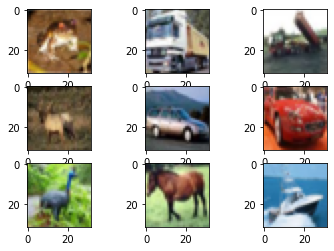

In [10]:
# plot first few images
for i in range(9):
 # define subplot
 plt.subplot(330 + 1 + i)
 # plot raw pixel data
 plt.imshow(data_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [169]:
# list of optimisers to be compared
# optimizer_names = for plotting purposes
optimizer_names = ['SGD','Adagrad','RMSprop','Nesterovs Momentum','Adam']
# optimizer_list = methods to be tested along with any specific parameter
optimizer_list = [
    keras.optimizers.SGD(learning_rate=0.001),  # SGD
    keras.optimizers.Adagrad(learning_rate=0.001),  # Adagrad
    keras.optimizers.RMSprop(learning_rate=0.001),  # RMSprop
    keras.optimizers.SGD(learning_rate=0.001, momentum=0.5, nesterov=True),  # Nesterov Momentum SGD
    keras.optimizers.Adam(learning_rate=0.001)  # Adam
]

In [68]:
n_epochs = 100
mini_batch = 128

# 3 x (CNN + MaxPooling) without Dropout

In [104]:
def build_compile(optimizer, use_dropout=False):
    
    model = Sequential()
    # 1st conv + maxpooling
    model.add(Conv2D(32, (5, 5), activation='relu',input_shape=(32, 32, 3), padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 2nd conv + maxpooling
    model.add(Conv2D(64, (5, 5), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3rd conv + maxpooling
    model.add(Conv2D(128, (5, 5), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # flatten layer
    model.add(Flatten())

    # FC 1000
    model.add(Dense(1000, activation='relu', kernel_initializer=keras.initializers.HeNormal()))
    # output layer 10 class
    model.add(Dense(10, activation='softmax', kernel_initializer=keras.initializers.HeNormal()))

    # complie model
    model.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    # summary of model
    model.summary()
    return model

In [106]:
# Record training and validation performance
hist_acc_nn = []       # Store training accuracy per optimizer
hist_val_acc_nn = []   # Store validation accuracy 
hist_loss_nn = []      # Store training loss 
hist_val_loss_nn = []  # Store validation loss 

start_time = time.time()
x_train, x_val, y_train, y_val = train_test_split(data_train, label_train, test_size=0.2, random_state=1)

# Iterate over different optimizers
for optimizer, name in zip(optimizer_list, optimizer_names):
    print("-----------------------------")
    print("Using %s optimizer" % str(name))
    print("-----------------------------")

    # Get the model with the selected optimizer
    model = build_compile(optimizer)  
    optimizer = model.optimizer
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    
    # List to store training history for each optimizer
    train_acc_per_epoch = []
    val_acc_per_epoch = []
    train_loss_per_epoch = []
    val_loss_per_epoch = []

    # replace model.fit since we need to randomly shuffle the whole dataset training dataset at the beginning of each epoch,
    # Then, only iterate through the first 50 mini-batches for one epoch training.
    for epoch in range(n_epochs):
        print(f"\nEpoch {epoch+1}/{n_epochs}")

        # Shuffle training data at the beginning of each epoch
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train_shuffled = x_train[indices]
        y_train_shuffled = y_train[indices]

        # Compute average loss and accuracy
        train_loss_metric = tf.keras.metrics.Mean()
        train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

        # Train only the first 50 mini-batches for one epoch
        for batch in range(50):  
            start = batch * mini_batch
            end = start + mini_batch
            x_batch, y_batch = x_train_shuffled[start:end], y_train_shuffled[start:end]

            # Compute gradients and update model parameters
            with tf.GradientTape() as tape:
                predictions = model(x_batch, training=True)  # Forward pass
                loss = loss_fn(y_batch, predictions)  # Compute loss
            
            gradients = tape.gradient(loss, model.trainable_variables)  # Compute gradients
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))  # Apply gradients

            # Update loss and accuracy metrics
            train_loss_metric(loss) # compute sum of loss and take average below
            train_acc_metric(y_batch, predictions)

        # Compute average training loss and accuracy for this epoch
        train_loss = train_loss_metric.result().numpy()
        train_acc = train_acc_metric.result().numpy()
        train_loss_per_epoch.append(train_loss)
        train_acc_per_epoch.append(train_acc)

        # Evaluate model on the validation set
        val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
        val_loss_per_epoch.append(val_loss)
        val_acc_per_epoch.append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    # Store training history for the optimizer
    hist_acc_nn.append(train_acc_per_epoch)
    hist_val_acc_nn.append(val_acc_per_epoch)
    hist_loss_nn.append(train_loss_per_epoch)
    hist_val_loss_nn.append(val_loss_per_epoch)
    
    # Print the test accuracy
    score = model.evaluate(data_test, label_test, verbose=0)
    accuracy = 100*score[1]
    print('Test accuracy %.2f%%' % accuracy)

end_time = time.time()
time = (end_time - start_time) / 60
print('Minutes to run: ', time)


-----------------------------
Using SGD optimizer
-----------------------------
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_123 (Conv2D)         (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d_123 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_124 (Conv2D)         (None, 16, 16, 64)        51264     
                                                                 
 max_pooling2d_124 (MaxPooli  (None, 8, 8, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_125 (Conv2D)         (None, 8, 8, 128)         204928    
                                       

The accuracy of test data is:

Mini-batch gradient descent: 37.65%

Mini-batch AdaGrad: 45.41%

Mini-batch RMSProp: 72.01%

Mini-batch gradient descent with Nesterov’s momentum: 44.51%

Mini-batch Adam: 70.9%

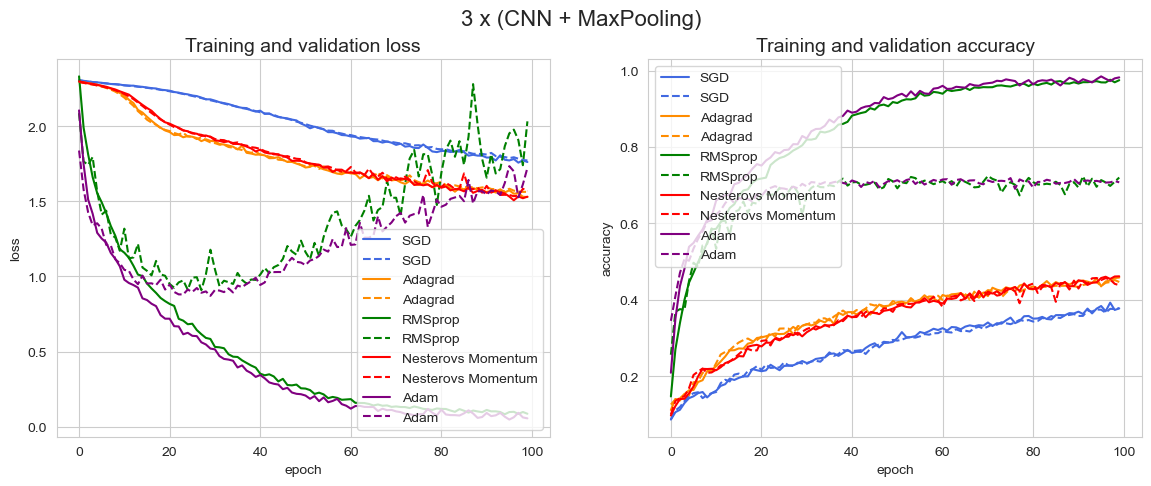

In [107]:
# loss and accuracy plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)
colors = ['royalblue', 'darkorange', 'green', 'red', 'purple', 'brown']

for i in range(len(optimizer_list)):
    color_idx = i % len(colors)  
    axes[0].plot(hist_loss_nn[i], linestyle='-', color=colors[color_idx], label= str(optimizer_names[i]))
    axes[0].plot(hist_val_loss_nn[i], linestyle='dashed', color=colors[color_idx], label=str(optimizer_names[i]))  

axes[0].set_title("Training and validation loss", fontsize=14)
axes[0].set_xlabel("epoch", fontsize=10)
axes[0].set_ylabel("loss", fontsize=10)
axes[0].legend(fontsize=10)

for i in range(len(optimizer_list)):
    color_idx = i % len(colors)
    axes[1].plot(hist_acc_nn[i], linestyle='-', color=colors[color_idx], label=str(optimizer_names[i]))
    axes[1].plot(hist_val_acc_nn[i], linestyle='dashed', color=colors[color_idx], label=str(optimizer_names[i]))  

axes[1].set_title("Training and validation accuracy", fontsize=14)
axes[1].set_xlabel("epoch", fontsize=10)
axes[1].set_ylabel("accuracy", fontsize=10)
axes[1].legend(fontsize=10)

fig.suptitle("3 x (CNN + MaxPooling)", fontsize=16)
plt.show()



The graphs shows the training(-) and validation(- -) loss and accuracy over 100 epochs for the 3-layer CNN model with max-pooling, using five different optimizers: SGD, Adagrad, RMSprop, Nesterov's Momentum, and Adam.

Adam achieves the best performance, with lowest loss and highest accuracy for both training and validation datasets. It converges fast within the first 20 epochs.
RMSprop is in the second place and has very similar results with Adam. 

But it's clear that there is heavy over fitting problem for these two since validation loss becomes greater after 20 epoches. The divergence is clear. So we need to consider adding dropout layers.

The other three optimizers didn't behave as good as Adam and RMSprop.


# 3 x (CNN + MaxPooling) + Dropout

In [171]:
def build_compile(optimizer):
    
    model = Sequential()
    # 1st conv + maxpooling + dropout
    model.add(Conv2D(32, (5, 5), activation='relu',input_shape=(32, 32, 3), padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.2))
    
    # 2nd conv + maxpooling + dropout
    model.add(Conv2D(64, (5, 5), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.2))
    
    # 3rd conv + maxpooling + dropout
    model.add(Conv2D(128, (5, 5), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.2))
    
    # flatten layer
    model.add(Flatten())

    # FC 1000 + dropout
    model.add(Dense(1000, activation='relu', kernel_initializer=keras.initializers.HeNormal()))
    model.add(Dropout(0.15))
    # output layer 10 class
    model.add(Dense(10, activation='softmax', kernel_initializer=keras.initializers.HeNormal()))

    # complie model
    model.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    # summary of model
    model.summary()
    return model

In [172]:
# we only use the best two optimizers here 
optimizer_names = ['RMSprop','Adam']
# optimizer_list = methods to be tested along with any specific parameter
optimizer_list = [
    keras.optimizers.RMSprop(learning_rate=0.001),  # RMSprop
    keras.optimizers.Adam(learning_rate=0.001)]  # Adam

In [173]:
# Record training and validation performance
hist_acc_nn = []       # Store training accuracy per optimizer
hist_val_acc_nn = []   # Store validation accuracy 
hist_loss_nn = []      # Store training loss 
hist_val_loss_nn = []  # Store validation loss 

import time
start_time = time.time()
x_train, x_val, y_train, y_val = train_test_split(data_train, label_train, test_size=0.2, random_state=2025)

# Iterate over different optimizers
for optimizer, name in zip(optimizer_list, optimizer_names):
    print("-----------------------------")
    print("Using %s optimizer" % str(name))
    print("-----------------------------")

    # Get the model with the selected optimizer
    model = build_compile(optimizer)  
    optimizer = model.optimizer
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    
    # List to store training history for each optimizer
    train_acc_per_epoch = []
    val_acc_per_epoch = []
    train_loss_per_epoch = []
    val_loss_per_epoch = []

    # replace model.fit since we need to randomly shuffle the whole dataset training dataset at the beginning of each epoch,
    # Then, only iterate through the first 50 mini-batches for one epoch training.
    for epoch in range(n_epochs):
        print(f"\nEpoch {epoch+1}/{n_epochs}")

        # Shuffle training data at the beginning of each epoch
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train_shuffled = x_train[indices]
        y_train_shuffled = y_train[indices]

        # Compute average loss and accuracy
        train_loss_metric = tf.keras.metrics.Mean()
        train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

        # Train only the first 50 mini-batches for one epoch
        for batch in range(50):  
            start = batch * mini_batch
            end = start + mini_batch
            x_batch, y_batch = x_train_shuffled[start:end], y_train_shuffled[start:end]

            # Compute gradients and update model parameters
            with tf.GradientTape() as tape:
                predictions = model(x_batch, training=True)  # Forward pass
                loss = loss_fn(y_batch, predictions)  # Compute loss
            
            gradients = tape.gradient(loss, model.trainable_variables)  # Compute gradients
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))  # Apply gradients

            # Update loss and accuracy metrics
            train_loss_metric(loss) # compute sum of loss and take average below
            train_acc_metric(y_batch, predictions)

        # Compute average training loss and accuracy for this epoch
        train_loss = train_loss_metric.result().numpy()
        train_acc = train_acc_metric.result().numpy()
        train_loss_per_epoch.append(train_loss)
        train_acc_per_epoch.append(train_acc)

        # Evaluate model on the validation set
        val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
        val_loss_per_epoch.append(val_loss)
        val_acc_per_epoch.append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    # Store training history for the optimizer
    hist_acc_nn.append(train_acc_per_epoch)
    hist_val_acc_nn.append(val_acc_per_epoch)
    hist_loss_nn.append(train_loss_per_epoch)
    hist_val_loss_nn.append(val_loss_per_epoch)
    
    # Print the test accuracy
    score = model.evaluate(data_test, label_test, verbose=0)
    accuracy = 100*score[1]
    print('Test accuracy %.2f%%' % accuracy)

end_time = time.time()
time = (end_time - start_time) / 60
print('Minutes to run: ', time)

-----------------------------
Using RMSprop optimizer
-----------------------------
Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_225 (Conv2D)         (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d_225 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_226 (Conv2D)         (None, 16, 16, 64)        51264     
                                                                 
 max_pooling2d_226 (MaxPooli  (None, 8, 8, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_227 (Conv2D)         (None, 8, 8, 128)         204928    
                                   

The accuracy of test data is:

Mini-batch RMSProp: 68.48%

Mini-batch Adam: 71.09%

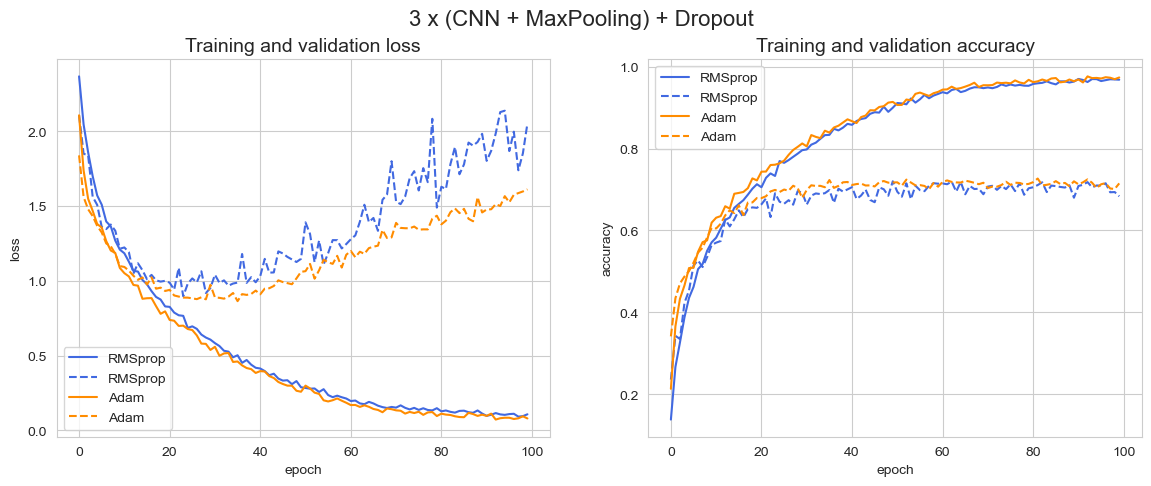

In [174]:
# loss and accuracy plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)
colors = ['royalblue', 'darkorange', 'green', 'red', 'purple', 'brown']

for i in range(len(optimizer_list)):
    color_idx = i % len(colors)  
    axes[0].plot(hist_loss_nn[i], linestyle='-', color=colors[color_idx], label= str(optimizer_names[i]))
    axes[0].plot(hist_val_loss_nn[i], linestyle='dashed', color=colors[color_idx], label=str(optimizer_names[i]))  

axes[0].set_title("Training and validation loss", fontsize=14)
axes[0].set_xlabel("epoch", fontsize=10)
axes[0].set_ylabel("loss", fontsize=10)
axes[0].legend(fontsize=10)

for i in range(len(optimizer_list)):
    color_idx = i % len(colors)
    axes[1].plot(hist_acc_nn[i], linestyle='-', color=colors[color_idx], label=str(optimizer_names[i]))
    axes[1].plot(hist_val_acc_nn[i], linestyle='dashed', color=colors[color_idx], label=str(optimizer_names[i]))  

axes[1].set_title("Training and validation accuracy", fontsize=14)
axes[1].set_xlabel("epoch", fontsize=10)
axes[1].set_ylabel("accuracy", fontsize=10)
axes[1].legend(fontsize=10)

fig.suptitle("3 x (CNN + MaxPooling) + Dropout", fontsize=16)
plt.show()

I added a relatively small dropout layer (0.15) after the dense layer. Compared to the previous validation loss, which was around 2 and 1.7, it has now clearly decreased, indicating that the dropout layer has indeed helped reduce overfitting. I did not use a larger dropout because it might reduce the model's accuracy.